In [1]:

!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt

Cloning into 'Quantum_KAN'...
remote: Enumerating objects: 835, done.
remote: Counting objects: 100% (835/835), done.
remote: Compressing objects: 100% (777/777), done.
remote: Total 835 (delta 118), reused 743 (delta 55), pack-reused 0
Receiving objects: 100% (835/835), 19.07 MiB | 24.05 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/Quantum_KAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit.compiler import transpile
def create_trotterized_ising_model_circuit(num_qubits, trotter_steps, time):
    """
    Trotterization을 사용하여 Ising 모델의 양자 서킷을 생성합니다.
    각 Rz 게이트의 파라미터는 Qiskit Parameter로 동적으로 설정됩니다.

    Parameters:
    - num_qubits: 큐비트의 수
    - trotter_steps: Trotterization 단계 수
    - time: 진화 시간

    Returns:
    - QuantumCircuit: 생성된 양자 서킷
    - dict: 서킷 파라미터 사전
    """
    qc = QuantumCircuit(num_qubits)
    delta_t = time / trotter_steps

    # 파라미터 설정
    h_params = [Parameter(f'h_{i}') for i in range(num_qubits)]
    J_params = [[Parameter(f'J_{i}_{j}') for j in range(num_qubits)] for i in range(num_qubits)]

    for _ in range(trotter_steps):
        # 자기 상호작용 항목 추가
        for i in range(num_qubits):
            qc.rx(2 * h_params[i] * delta_t, i)

        # 스핀 간 상호작용 항목 추가
        for i in range(num_qubits-1):
            if J_params[i][i+1] != 0:
                qc.cx(i, i+1)
                qc.rz(2 * J_params[i][i+1] * delta_t, i+1)
                qc.cx(i, i+1)

    return qc, h_params, J_params


# ECR 게이트를 제거하는 함수
def remove_ecr_gates(circuit):
    new_circuit = QuantumCircuit(circuit.num_qubits)
    for instr, qargs, cargs in circuit.data:
        if instr.name != 'ecr':
            new_circuit.append(instr, qargs, cargs)
    return new_circuit

def create_trotterized_ising_model_circuit_train(num_qubits, trotter_steps, time):
    """
    Trotterization을 사용하여 Ising 모델의 양자 서킷을 생성합니다.
    각 Rz 게이트의 파라미터는 Qiskit Parameter로 동적으로 설정됩니다.

    Parameters:
    - num_qubits: 큐비트의 수
    - trotter_steps: Trotterization 단계 수
    - time: 진화 시간

    Returns:
    - QuantumCircuit: 생성된 양자 서킷
    - dict: 서킷 파라미터 사전
    """
    qc = QuantumCircuit(num_qubits)
    delta_t = time / trotter_steps

    # 파라미터 설정
    h_params = [Parameter(f'h_{i}') for i in range(num_qubits)]
    J_params = [[Parameter(f'J_{i}_{j}') for j in range(num_qubits)] for i in range(num_qubits)]

    for _ in range(trotter_steps):
        # 자기 상호작용 항목 추가
        for i in range(num_qubits):
            qc.rx(2 * h_params[i] * delta_t, i)

       # 스핀 간 상호작용 항목 추가
        for i in range(num_qubits-1):
            if J_params[i][i+1] != 0:
                qc.rz(-np.pi/2,i)
                qc.rz(-np.pi,i+1)
                qc.sx(i+1)
                qc.rz(-np.pi,i+1)
                qc.x(i)

                qc.rz(2 * J_params[i][i+1] * delta_t, i+1)

                qc.rz(-np.pi/2,i)
                qc.rz(-np.pi,i+1)
                qc.sx(i+1)
                qc.rz(-np.pi,i+1)
                qc.x(i)

    return qc, h_params, J_params

# 파라미터 설정
num_qubits = 4
trotter_steps = 2  # Trotterization 단계 수
time = 1.0  # 진화 시간

In [9]:


# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_ibm_provider
from qiskit_aer import AerSimulator
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')

backend_name = 'ibm_nazca'
backend_error = service.backend(backend_name)

#qubit_use = [37,38,39,40,41,42,43]
qubit_use = [0,1,2,3]


init_list = []
for item in backend_error.target['ecr']:
    if item[0] in qubit_use and item[1] in qubit_use:
        init_list.append(item)

trotterized_ising_circuit, h_params, J_params = create_trotterized_ising_model_circuit(num_qubits, trotter_steps, time)
trotterized_ising_circuit = transpile(trotterized_ising_circuit,basis_gates=['rz','sx','x','ecr'],coupling_map=[list(i) for i in init_list],optimization_level=2)
trotterized_ising_circuit_train = remove_ecr_gates(trotterized_ising_circuit)

In [67]:
# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_ibm_provider
from qiskit_aer import AerSimulator
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')

backend_name = backend_name
backend = service.backend(backend_name)

In [92]:
#setting
optimization_level = 0
resilience_level = 1
l = 2

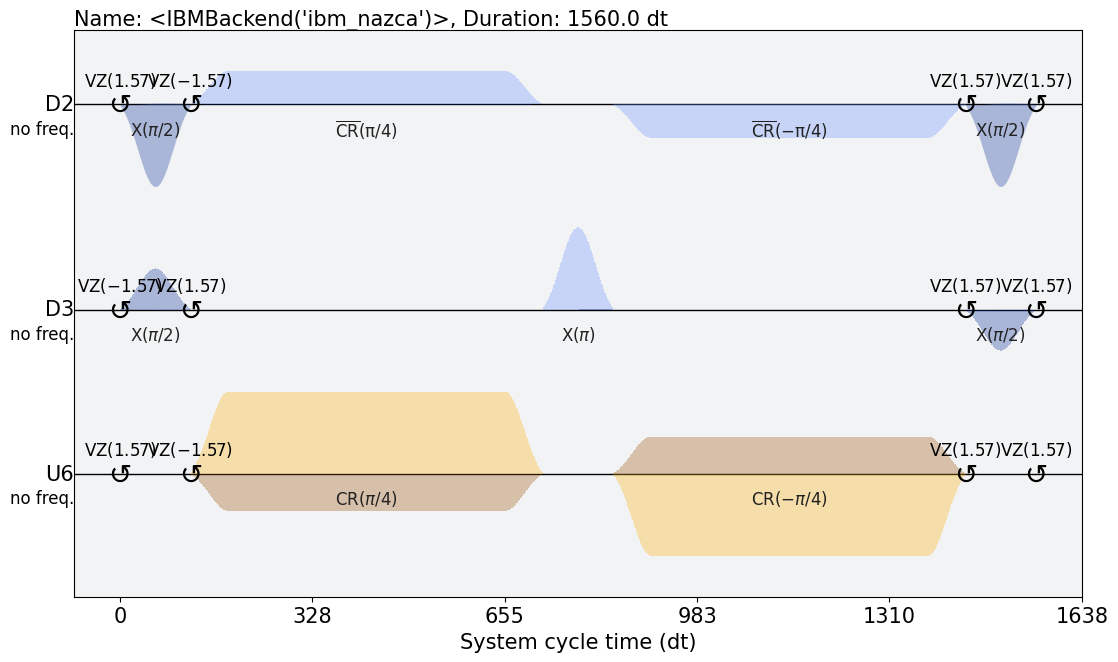

In [93]:
from qiskit import QuantumCircuit
from qiskit import pulse
from qiskit import schedule
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Options
from qiskit.pulse.library import Gaussian
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=[2,3])



circ = QuantumCircuit(2, 2)
circ.ecr(0, 1)
from qiskit import transpile
circ = passmanager.run(circ,backend)
pulse_schedule = schedule(circ,backend=backend)
pulse_schedule.draw()

In [94]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel,Schedule,GaussianSquare,Drag,Play,ScheduleBlock,Delay
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 ,SamplerV2
from qiskit_ibm_runtime import Session
import numpy as np


init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)

def ecr_to_error(pulse_schedule,l):
  pulse_copy = copy.deepcopy(pulse_schedule)
  duration = round(pulse_copy.instructions[0][1].pulse.duration/32*l)*16
  width = round(pulse_copy.instructions[0][1].pulse._params['width']/32*l)*16
  x_duration = pulse_copy.instructions[2][1].pulse.duration
  sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32*l)*16
  if sigma == 0:
    sigma = 1
  my_schedule = ScheduleBlock()
  signal_params = {'width':width,'sigma':sigma}
  for j in range(2):
    pulse_copy = copy.deepcopy(pulse_schedule)
    pulse_input_x_1 = pulse_copy.instructions[0][1]
    pulse_input_x_2 = pulse_copy.instructions[3][1]
    pulse_input_c_1 = pulse_copy.instructions[1][1]
    #pulse_input_c_1.pulse._params['angle'] = 0
    pulse_input_c_1.pulse._params.update(signal_params)
    pulse_input_c_1.pulse.duration = duration
    pulse_input_x_1.pulse._params.update(signal_params)
    pulse_input_x_1.pulse.duration = duration
    pulse_input_drag = pulse_copy.instructions[2][1]
    if j == 1:
        pulse_input_drag.pulse._params['angle'] = 3.14
    pulse_input_c_2 = pulse_copy.instructions[4][1]
    pulse_input_c_2.pulse._params.update(signal_params)
    pulse_input_c_2.pulse.duration = duration
    pulse_input_x_2.pulse._params.update(signal_params)
    pulse_input_x_2.pulse.duration = duration
    real_pulse = ScheduleBlock()
    real_pulse += pulse_input_c_1
    real_pulse += pulse_input_x_1
    real_pulse += Delay(x_duration,pulse_input_c_1.channel)
    real_pulse += Delay(x_duration,pulse_input_x_1.channel)
    real_pulse +=  pulse_input_c_2
    real_pulse += pulse_input_x_2
    real_pulse += Delay(duration,pulse_input_drag.channel)
    real_pulse += pulse_input_drag
    my_schedule += real_pulse
  return my_schedule


def ecr_to_schedule(pulse_schedule):
  pulse_copy = copy.deepcopy(pulse_schedule)
  my_schedule = ScheduleBlock()
  x_duration = pulse_copy.instructions[2][1].pulse.duration
  duration = pulse_copy.instructions[0][1].pulse.duration
  pulse_input_x_1 = pulse_copy.instructions[0][1]
  pulse_input_x_2 = pulse_copy.instructions[3][1]
  pulse_input_c_1 = pulse_copy.instructions[1][1]
  pulse_input_drag = pulse_copy.instructions[2][1]
  pulse_input_c_2 = pulse_copy.instructions[4][1]
  real_pulse = ScheduleBlock()
  real_pulse += pulse_input_c_1
  real_pulse += pulse_input_x_1
  real_pulse += Delay(x_duration,pulse_input_c_1.channel)
  real_pulse += Delay(x_duration,pulse_input_x_1.channel)
  real_pulse +=  pulse_input_c_2
  real_pulse += pulse_input_x_2
  real_pulse += Delay(duration,pulse_input_drag.channel)
  real_pulse += pulse_input_drag
  my_schedule += real_pulse
  return my_schedule



def update_ecr(l,init_list,backend):
  backend_copy = copy.deepcopy(backend)
  layouts = {}
  for initial_layout in init_list:
    custom_gate = Gate(f"error", 2, [])
    pulse_schedule = backend_copy.target['ecr'][initial_layout].calibration
    pulse_real = ecr_to_error(pulse_schedule,1)


    if l == 0:
      backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real)))
    else:
      my_schedule = ecr_to_error(pulse_schedule,l)
      backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real+my_schedule)))



  return backend_copy


backend_error = update_ecr(l,init_list,backend)
initial_layout = init_list[0]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


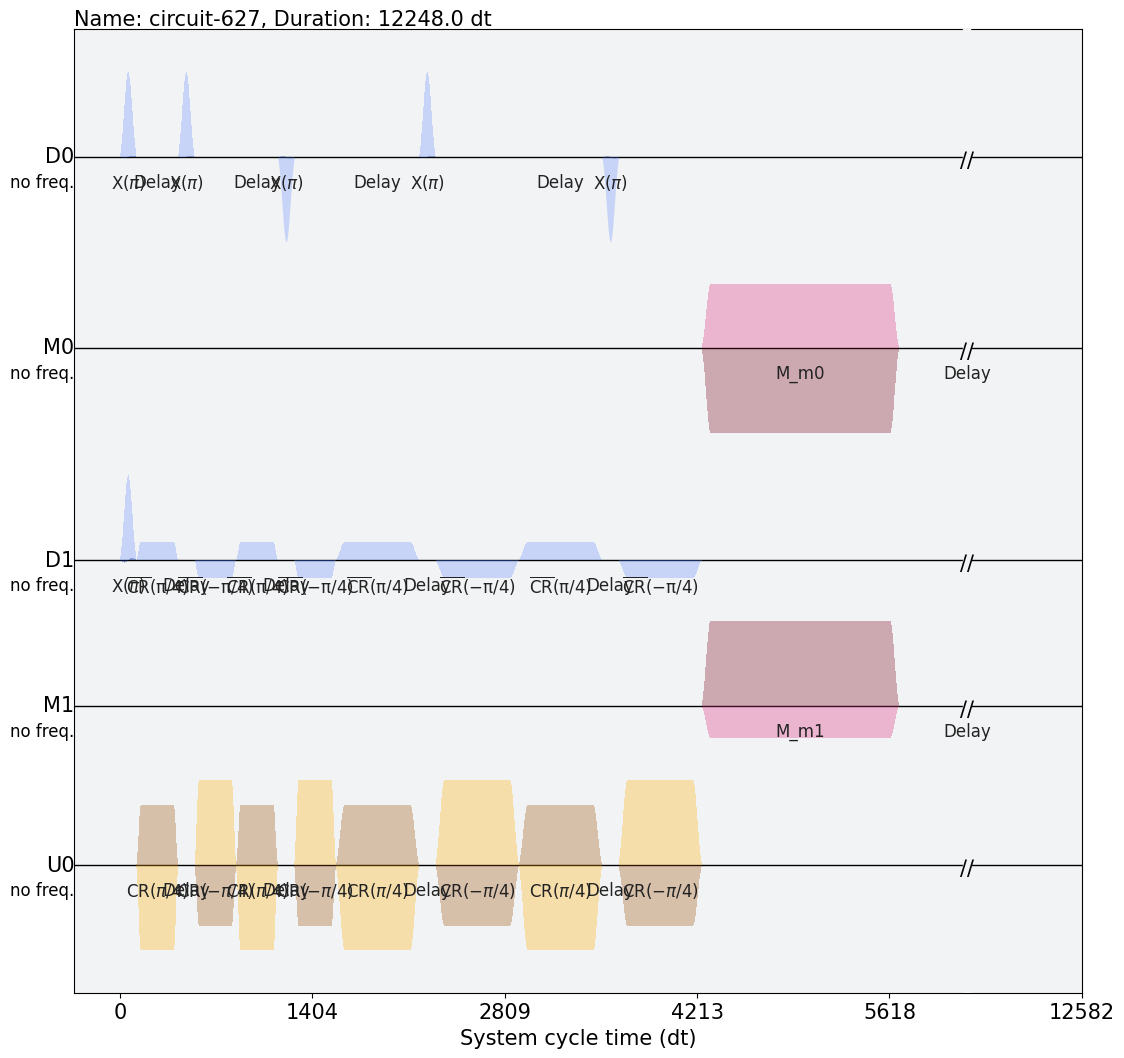

In [95]:
schedule(qc1,backend=backend_error).draw()

In [96]:

passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_error, initial_layout=qubit_use[:4])

from qiskit.quantum_info import SparsePauliOp
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,len(trotterized_ising_circuit.parameters)])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)
with Session(backend=backend_error,) as session:
    estimator = EstimatorV2(session=session)
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
    #job = sampler.run(qc_list,shots=8000)
    job.update_tags(['ecr_train',f"l={1+l}"])

<ipython-input-96-ca0205cff756>:10: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(session=session)


In [97]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2,SamplerV2
from qiskit_ibm_runtime import Session
init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)

def update_ecr_real(l,init_list,backend):
  backend_copy = copy.deepcopy(backend)
  layouts = {}
  for initial_layout in init_list:
    pulse_schedule = backend_copy.target['ecr'][initial_layout].calibration
    pulse_real = ecr_to_schedule(pulse_schedule)

    if l == 0:
      backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real)))
    else:
      my_schedule = ecr_to_error(pulse_schedule,l)
      backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real+my_schedule)))



  return backend_copy




backend_ecr = update_ecr_real(l,init_list,backend)
initial_layout = init_list[1]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


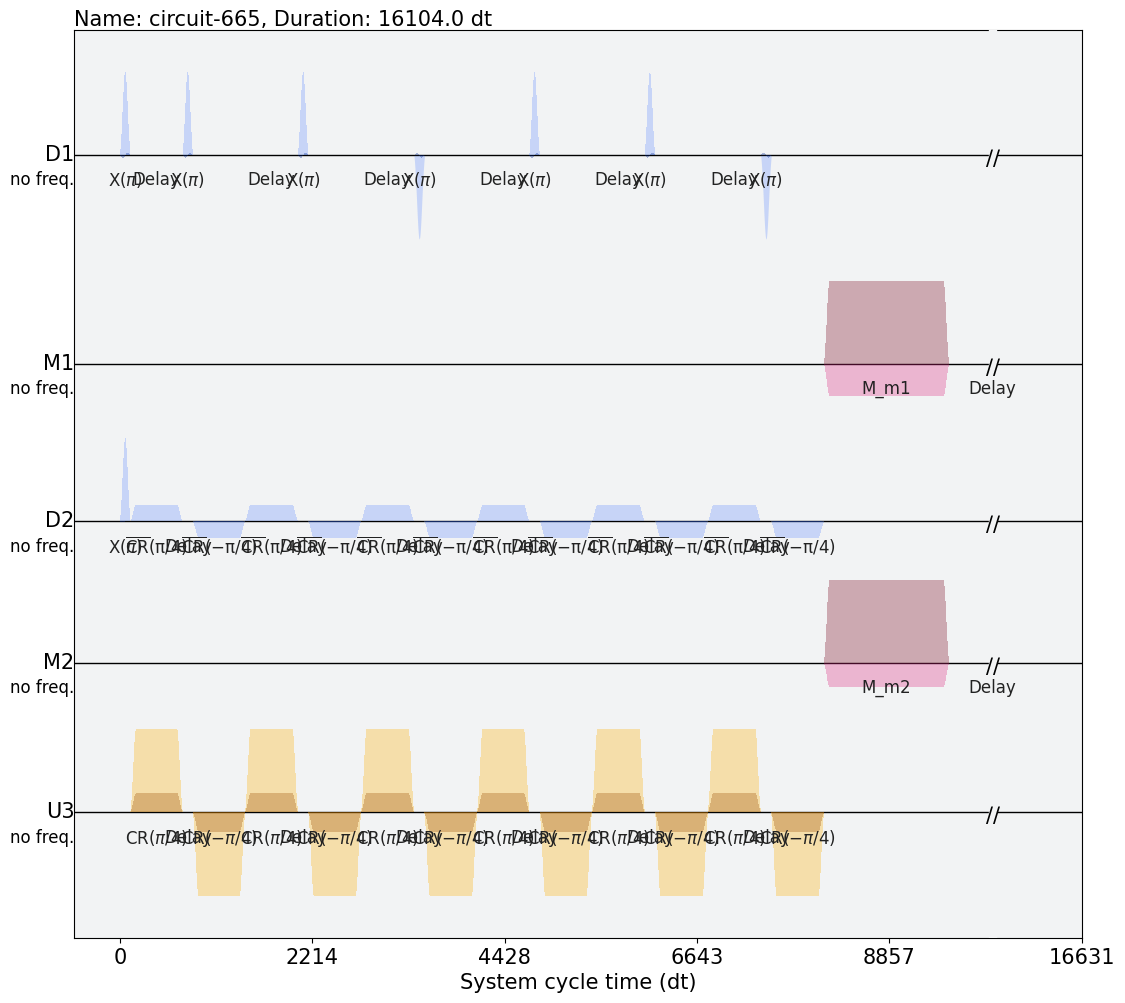

In [98]:
schedule(qc1,backend=backend_ecr).draw()

In [99]:
passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_ecr, initial_layout=qubit_use[:4])

from qiskit.quantum_info import SparsePauliOp
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,len(trotterized_ising_circuit.parameters)])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)



with Session(backend=backend_ecr) as session:
    estimator = EstimatorV2(session=session)
    estimator.resilience_level = resilience_level
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
    #job = sampler.run(qc_list,shots=8000)
    job.update_tags(['ecr',f"l={1+l}"])

<ipython-input-99-3f4001cb2b6f>:13: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(session=session)


In [106]:
from qiskit.primitives import StatevectorEstimator
import torch
from qiskit.quantum_info import SparsePauliOp
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,len(trotterized_ising_circuit.parameters)])
estimator = StatevectorEstimator()
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
job_train = estimator.run([(trotterized_ising_circuit_train, hamiltonian, theta[i]) for i in range(100)])
job_valid = estimator.run([(trotterized_ising_circuit, hamiltonian, theta[i]) for i in range(100)])

In [107]:
train_label = torch.tensor(np.array([result.data.evs for result in job_train.result()]),dtype=torch.float32)
validation_label = torch.tensor(np.array([result.data.evs for result in job_valid.result()]),dtype=torch.float32)

In [114]:
import torch
l_list = [1,2,3]
train_set = []
valid_set = []

for l in l_list:
  train_list = []
  valid_list = []

  job_train = service.jobs(backend_name=backend_name,job_tags=['ecr_train',f'l={l}'],pending=False)
  job_valid = service.jobs(backend_name=backend_name,job_tags=['ecr',f'l={l}'],pending=False)
  for res in job_train[0].result():
    train_list.append(res.data.evs)

  for res in job_valid[0].result():
    valid_list.append(res.data.evs)

  train_set.append(torch.tensor(np.array(train_list),dtype=torch.float32))
  valid_set.append(torch.tensor(np.array(valid_list),dtype=torch.float32))


In [115]:
train_data = torch.stack(train_set,dim=1)
train_data = train_data.to(torch.float32)
validation_data = torch.stack(valid_set,dim=1)
validation_data = validation_data.to(torch.float32)
#train_data = validation_data[:50]
#validation_data = validation_data[50:]
#train_label = validation_label[:50]
#validation_label = validation_label[50:]

<ipython-input-135-230cc66ba31d>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_label))
<ipython-input-135-230cc66ba31d>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_dataset = TensorDataset(torch.tensor(validation_data), torch.tensor(validation_label))


Epoch 1/200, Training Loss: 2.370816707611084, Validation Loss: 5.3954033851623535
Epoch 2/200, Training Loss: 2.2533295154571533, Validation Loss: 5.109892845153809
Epoch 3/200, Training Loss: 2.1376242637634277, Validation Loss: 4.810882568359375
Epoch 4/200, Training Loss: 2.0184404850006104, Validation Loss: 4.485970497131348
Epoch 5/200, Training Loss: 1.891299843788147, Validation Loss: 4.123128414154053
Epoch 6/200, Training Loss: 1.7522177696228027, Validation Loss: 3.711414098739624
Epoch 7/200, Training Loss: 1.5981407165527344, Validation Loss: 3.2434864044189453
Epoch 8/200, Training Loss: 1.4281202554702759, Validation Loss: 2.7194387912750244
Epoch 9/200, Training Loss: 1.2450958490371704, Validation Loss: 2.1526119709014893
Epoch 10/200, Training Loss: 1.0585529804229736, Validation Loss: 1.5770697593688965
Epoch 11/200, Training Loss: 0.8878340721130371, Validation Loss: 1.0545108318328857
Epoch 12/200, Training Loss: 0.7642424702644348, Validation Loss: 0.6712306141853

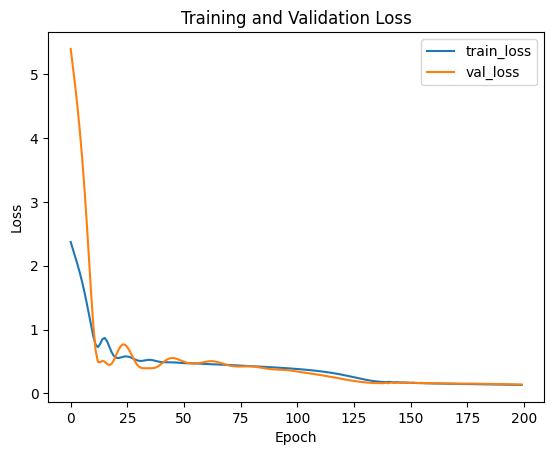

<built-in method stack of type object at 0x7ba210a81760>


<ipython-input-135-230cc66ba31d>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([3,1,1],grid=1)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output


# 데이터셋 및 데이터로더
train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_label))
validation_dataset = TensorDataset(torch.tensor(validation_data), torch.tensor(validation_label))
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=False)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(3, 64)
        self.layer2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        x = torch.squeeze(x)
        return x

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 은닉 상태 초기화
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 셀 상태 초기화
        out, _ = self.lstm(x, (h0, c0))  # LSTM을 통해 시퀀스 처리
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 fully connected layer에 적용하여 출력 생성
        out = torch.squeeze(out)
        return out

# 모델 초기화
model = LSTMModel(1,64,1)
# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# 모델 학습
num_epochs = 200
train_losses = []
validation_losses = []

for epoch in range(num_epochs):

    running_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))


    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    validation_losses.append(validation_loss / len(validation_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {validation_losses[-1]}')

# 손실(loss) 그래프
plt.plot(train_losses, label='train_loss')
plt.plot(validation_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 검증 데이터로 예측
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = model(validation_inputs)
    print(torch.stack)


In [136]:
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([validation_data[:,2],validation_data[:,1],validation_data[:,0],validation_label],dim=1))

tensor([[ 0.1193,  0.2741,  1.1982,  1.4259],
        [ 2.3511,  1.7280,  1.6576,  1.6026],
        [ 0.1901,  0.1246,  0.6399,  0.5703],
        [ 0.3702,  0.8545,  1.4509,  1.8966],
        [ 1.3367,  1.9313,  2.7980,  3.7646],
        [ 0.4011,  0.2980,  0.0291, -0.6956],
        [ 1.8718,  1.8637,  1.9400,  1.6477],
        [ 0.2313,  0.8763,  1.6570,  2.4636],
        [ 0.2154,  0.9593,  2.0480,  3.2466],
        [ 1.0248,  1.2833,  1.6395,  1.7071],
        [ 2.0384,  1.4261,  1.5593,  1.5128],
        [ 1.2889,  1.9412,  2.8531,  3.6812],
        [ 0.0850,  0.3354,  0.7766,  1.1207],
        [ 1.2416,  1.7399,  2.7419,  3.4969],
        [-0.1609,  0.2363,  0.9050,  1.3279],
        [ 1.2258,  1.8938,  2.5226,  3.3967],
        [ 0.8320,  0.6138,  1.1463,  1.8287],
        [ 0.4971,  0.8422,  1.6428,  2.1487],
        [-0.4436,  0.0328,  0.6055,  1.0300],
        [ 0.5153,  0.7583,  1.2294,  1.8514],
        [-0.3926,  0.1719,  0.6736,  0.6100],
        [ 0.7924,  1.4669,  2.1899

<ipython-input-136-20d70c153bb3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [141]:
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([predictions,validation_label],dim=1))

tensor([[ 2.0419,  1.4259],
        [ 1.1671,  1.6026],
        [ 1.2818,  0.5703],
        [ 1.9371,  1.8966],
        [ 3.4950,  3.7646],
        [-0.2279, -0.6956],
        [ 1.7069,  1.6477],
        [ 2.3030,  2.4636],
        [ 2.9402,  3.2466],
        [ 1.7619,  1.7071],
        [ 1.2614,  1.5128],
        [ 3.5906,  3.6812],
        [ 1.3774,  1.1207],
        [ 3.5292,  3.4969],
        [ 1.7094,  1.3279],
        [ 3.0393,  3.3967],
        [ 1.5494,  1.8287],
        [ 2.2446,  2.1487],
        [ 1.4172,  1.0300],
        [ 1.6283,  1.8514],
        [ 1.4234,  0.6100],
        [ 2.7725,  3.0484],
        [ 2.0177,  2.0972],
        [ 1.2627,  1.5724],
        [ 0.4950,  0.4467],
        [ 1.2466,  1.6926],
        [ 1.1286,  1.1059],
        [ 2.7922,  2.7588],
        [ 3.4696,  3.5101],
        [ 2.2761,  2.4779],
        [ 1.7833,  2.0721],
        [ 0.9491,  1.0565],
        [ 1.4822,  1.2308],
        [ 3.5431,  3.4392],
        [ 2.7707,  2.8417],
        [ 1.4610,  1

<ipython-input-141-577be693f5a7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [137]:
torch.nn.L1Loss()(predictions,validation_label)

tensor(0.2875)

In [142]:
torch.nn.MSELoss()(train_data[:,0],train_label)

tensor(0.3811)

In [25]:
with torch.no_grad():
    validation_inputs = torch.tensor(train_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([predictions,train_data[:,0],train_label],dim=1))

tensor([[-1.6506, -2.0117, -1.7761],
        [ 0.1638,  0.7133,  0.8210],
        [ 1.4798,  1.3035,  1.7418],
        [ 1.9013,  2.2874,  1.7055],
        [ 2.0914,  2.2313,  2.6926],
        [-0.6514, -0.6816, -1.6755],
        [-1.0940, -1.2119, -1.5860],
        [-0.7168, -0.7825,  0.6374],
        [ 0.0060, -0.0858,  0.2807],
        [ 0.3721,  0.2963, -0.0817],
        [-1.2267, -1.3494, -0.9588],
        [ 1.1904,  1.4902,  1.9551],
        [ 0.8933,  0.5739,  0.6847],
        [ 1.7550,  1.8833,  1.9082],
        [-0.6063, -0.6644,  0.2423],
        [ 0.8854,  1.2536,  1.3596],
        [-1.3499, -1.4464, -2.4078],
        [-0.0388,  0.0626,  0.5511],
        [ 0.0457,  0.3493, -0.8741],
        [-0.9404, -0.9952, -2.5777],
        [-1.8739, -2.8459, -2.8752],
        [-0.3303, -0.3963,  0.2016],
        [-1.1602, -1.1292, -0.9368],
        [-1.9136, -2.1406, -1.4690],
        [-1.8850, -2.3658, -3.2209],
        [ 0.3476,  0.4772,  0.1468],
        [-0.9684, -1.0224,  0.0475],
 

<ipython-input-25-a6e22bbf2531>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(train_data)


In [181]:
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')


backend = service.backend(backend_name)

In [124]:
passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, initial_layout=qubit_use[:4])

from qiskit.quantum_info import SparsePauliOp
"""
qc_list = []
for i in range(20):
    qc1 = QuantumCircuit(2, 2)
    if init[0] == '1':
        qc1.x(0)
    if init[1] == '1':
        qc1.x(1)
    #qc1.ecr(0,1)
    #qc1.ecr(0,1)
    for j in range(i):
        qc1.ecr(0,1)
        qc1.ecr(0,1)
    qc1.measure(0,0)
    qc1.measure(1,1)
    qc1 = passmanager.run(qc1)
    qc_list.append(qc1)"""
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,len(trotterized_ising_circuit.parameters)])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)
with Session(backend=backend,) as session:
    estimator = EstimatorV2(session=session)
    estimator.resilience_level = 2
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
    #job = sampler.run(qc_list,shots=8000)
    job.update_tags(['ZNE'])

<ipython-input-124-e497d18277bf>:27: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(session=session)


In [138]:
job = service.job('csmqdfnea560008fbxvg')
job_result = job.result()
temp_result = []
for res in job_result:
    temp_result.append(res.data.evs)
temp_result = torch.tensor(np.array(temp_result),dtype=torch.float32)

In [139]:
torch.nn.MSELoss()(temp_result,validation_label)

tensor(0.3898)

In [140]:
torch.nn.L1Loss()(temp_result,validation_label)

tensor(0.5345)